In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import matplotlib.pyplot as plt

from WindowGenerator import WindowGenerator

In [2]:
pd.DataFrame().ta.indicators()

pandas.ta - Technical Analysis Indicators - v0.1.66b
Total Indicators: 107
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, decreasing, dema, donchian, dpo, efi, ema, entropy, eom, fisher, fwma, ha, hl2, hlc3, hma, ichimoku, increasing, kama, kc, kdj, kst, kurtosis, linear_decay, linreg, log_return, long_run, macd, mad, massi, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, ppo, psar, psl, pvi, pvol, pvt, pwma, qstick, quantile, rma, roc, rsi, rvi, short_run, sinwma, skew, slope, sma, stdev, stoch, supertrend, swma, t3, tema, trend_return, trima, trix, true_range, tsi, uo, variance, vortex, vp, vwap, vwma, wcp, willr, wma, zlma, zscore


In [3]:
df = pd.read_csv('BTC_USD_2015-10-08_2020-05-27_Gemini_Hourly.csv')
df.set_index('Date', inplace=True)
df.drop(['currency', 'open', 'high', 'low', 'volume'], axis=1, inplace=True)
# df.drop(['currency'], axis=1, inplace=True)
# df.loc[:, 'ema'] = df.ta.ema(12)
# df.loc[:, 'sma'] = df.ta.sma(12)
# df.loc[:, 'log'] = pd.Series(np.log(df.close.values), index=df.index)
# df.loc[:, 'hma'] = df.ta.hma(12)
df.loc[:, 'ema12'] = df.ta.ema(12)
df.loc[:, 'ema24'] = df.ta.ema(24)
df.loc[:, 'ema48'] = df.ta.ema(48)
# df.loc[:, 'sma12'] = df.ta.sma(12)
# df.loc[:, 'sma24'] = df.ta.sma(24)
# df.loc[:, 'sma48'] = df.ta.sma(48)
df = df[48:]
df.head(10)

,close,ema12,ema24,ema48
Date,,,,
2015-10-11 00:00:00,246.3,245.733371,245.733371,245.733371
2015-10-11 01:00:00,246.3,245.836394,245.836394,245.836394
2015-10-11 02:00:00,246.3,245.920686,245.920686,245.920686
2015-10-11 03:00:00,246.3,245.989652,245.989652,245.989652
2015-10-11 04:00:00,246.3,246.046079,246.046079,246.046079
2015-10-11 05:00:00,246.3,246.092247,246.092247,246.092247
2015-10-11 06:00:00,246.3,246.130020,246.130020,246.130020
2015-10-11 07:00:00,246.3,246.160925,246.160925,246.160925
2015-10-11 08:00:00,246.3,246.186212,246.186212,246.186212


In [4]:
# Split data
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

INPUT_WIDTH = 24
LABEL_SHIFT = 4
MAX_EPOCHS = 50
STD = train_df.close.std()
MEAN = train_df.close.mean()

In [5]:
# Standardise data
def standardise(df, column, mean, std):
    vals = df[col].values
    df.loc[:, column+'_normal'] = pd.Series((vals - mean) / std, index=df.index)

cols = [x for x in train_df.columns]

for col in cols:
    vals = train_df[col].values
    mean = vals.mean()
    std = vals.std()
    print(f'{col} mean: {mean}')
    print(f'{col} std: {std}')
    for df in [train_df, test_df, val_df]:
        standardise(df, col, mean, std)

train_df.drop(cols, axis=1, inplace=True)
val_df.drop(cols, axis=1, inplace=True)
test_df.drop(cols, axis=1, inplace=True)

train_df.head()

close mean: 3761.2723815320564
close std: 3877.940841095621
ema12 mean: 3760.707187273478
ema12 std: 3876.88731368174
ema24 mean: 3760.707187273478
ema24 std: 3876.88731368174
ema48 mean: 3760.707187273478
ema48 std: 3876.88731368174


,close_normal,ema12_normal,ema24_normal,ema48_normal
Date,,,,
2015-10-11 00:00:00,-0.906402,-0.906648,-0.906648,-0.906648
2015-10-11 01:00:00,-0.906402,-0.906622,-0.906622,-0.906622
2015-10-11 02:00:00,-0.906402,-0.906600,-0.906600,-0.906600
2015-10-11 03:00:00,-0.906402,-0.906582,-0.906582,-0.906582
2015-10-11 04:00:00,-0.906402,-0.906568,-0.906568,-0.906568


In [43]:
window = WindowGenerator(input_width=INPUT_WIDTH, label_width=1, shift=LABEL_SHIFT, 
                         train_df=train_df, val_df=val_df, test_df=test_df,
                         label_columns=['close_normal'])
window

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [27]
Label column name(s): ['close_normal']

In [44]:
LSTM_SIZE = INPUT_WIDTH*len(df.columns)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.compat.v1.keras.layers.CuDNNLSTM(LSTM_SIZE),
    tf.keras.layers.Dense(int(LSTM_SIZE/2), activation="relu"),
    tf.keras.layers.Dense(int(LSTM_SIZE/4), activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(loss=tf.losses.MeanAbsolutePercentageError(),
            optimizer=tf.optimizers.Adam())
            # metrics=[tf.metrics.MeanAbsolutePercentageError()])

history = model.fit(window.train, epochs=MAX_EPOCHS, batch_size=96, validation_data=window.val, verbose=1)

Epoch 1/50
885/885 [==============================] - 6s 7ms/step - loss: 15.0876 - val_loss: 27.1339
Epoch 2/50
885/885 [==============================] - 5s 6ms/step - loss: 12.0413 - val_loss: 24.1928
Epoch 3/50
885/885 [==============================] - 5s 6ms/step - loss: 9.8449 - val_loss: 29.9266
Epoch 4/50
885/885 [==============================] - 5s 6ms/step - loss: 10.5441 - val_loss: 25.0023
Epoch 5/50
885/885 [==============================] - 5s 6ms/step - loss: 9.6711 - val_loss: 21.7684
Epoch 6/50
885/885 [==============================] - 5s 6ms/step - loss: 8.6348 - val_loss: 25.1312
Epoch 7/50
885/885 [==============================] - 5s 6ms/step - loss: 8.5077 - val_loss: 27.6805
Epoch 8/50
885/885 [==============================] - 5s 6ms/step - loss: 9.1278 - val_loss: 20.1806
Epoch 9/50
885/885 [==============================] - 5s 6ms/step - loss: 8.2793 - val_loss: 25.0505
Epoch 10/50
885/885 [==============================] - 5s 6ms/step - loss: 7.8729 - val_

In [45]:
for layer in model.layers:
    print(layer.input_shape)

(None, 24, 4)
(None, 96)
(None, 96, 1)
(None, 96)
(None, 48)
(None, 24)


Minimum training loss: 6.0864152908325195
Minimum validation loss: 15.585126876831055


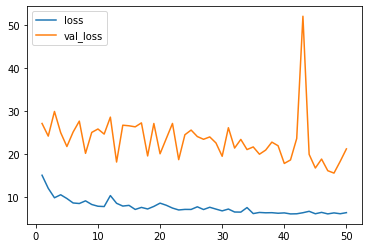

In [46]:
SPLIT = 0
min_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])

print(f'Minimum training loss: {min_loss}')
print(f'Minimum validation loss: {min_val_loss}')

plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['loss'][SPLIT:], label='loss')
plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['val_loss'][SPLIT:], label='val_loss')
plt.legend()
plt.show()

# plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['mean_absolute_percentage_error'][SPLIT:], label='mape')
# plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['val_mean_absolute_percentage_error'][SPLIT:], label='val_mape')
# plt.legend()

In [48]:
history = model.fit(window.val, epochs=int(MAX_EPOCHS/2), batch_size=1, verbose=1)

Epoch 1/25
253/253 [==============================] - 1s 6ms/step - loss: 12.1494
Epoch 2/25
253/253 [==============================] - 1s 5ms/step - loss: 11.9566
Epoch 3/25
253/253 [==============================] - 1s 5ms/step - loss: 12.4494
Epoch 4/25
253/253 [==============================] - 1s 5ms/step - loss: 10.9862
Epoch 5/25
253/253 [==============================] - 1s 5ms/step - loss: 11.8616
Epoch 6/25
253/253 [==============================] - 1s 5ms/step - loss: 10.7871
Epoch 7/25
253/253 [==============================] - 1s 5ms/step - loss: 12.4873
Epoch 8/25
253/253 [==============================] - 1s 5ms/step - loss: 11.5080
Epoch 9/25
253/253 [==============================] - 1s 5ms/step - loss: 11.1919
Epoch 10/25
253/253 [==============================] - 1s 5ms/step - loss: 11.2184
Epoch 11/25
253/253 [==============================] - 1s 5ms/step - loss: 12.8576
Epoch 12/25
253/253 [==============================] - 1s 5ms/step - loss: 12.6153
Epoch 13/25
2

Minimum training loss: 10.473934173583984


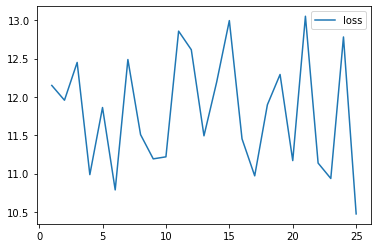

In [52]:
SPLIT = 0
min_loss = min(history.history['loss'])
# min_val_loss = min(history.history['val_loss'])

print(f'Minimum training loss: {min_loss}')
# print(f'Minimum validation loss: {min_val_loss}')

plt.plot([x for x in range(1, int(MAX_EPOCHS/2)+1)][SPLIT:], history.history['loss'][SPLIT:], label='loss')
# plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['val_loss'][SPLIT:], label='val_loss')
plt.legend()
plt.show()

# plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['mean_absolute_percentage_error'][SPLIT:], label='mape')
# plt.plot([x for x in range(1, MAX_EPOCHS+1)][SPLIT:], history.history['val_mean_absolute_percentage_error'][SPLIT:], label='val_mape')
# plt.legend()

In [53]:
model.evaluate(window.test)

126/126 [==============================] - 2s 15ms/step - loss: 2.3600


2.359955310821533


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: Sett

Diff is 31.072610698225617
Diff is 19.172826981995968
Diff is 3.4567361504596192
Diff is 16.4790698943998
Diff is 58.63238644403191
Diff is 10.813917321983354
Diff is 1.8404380891224719


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/pandas/core/indexing.py:845: Sett

Diff is 1.2042113300030906
Diff is -28.21896329316587
Diff is -0.446949601322558


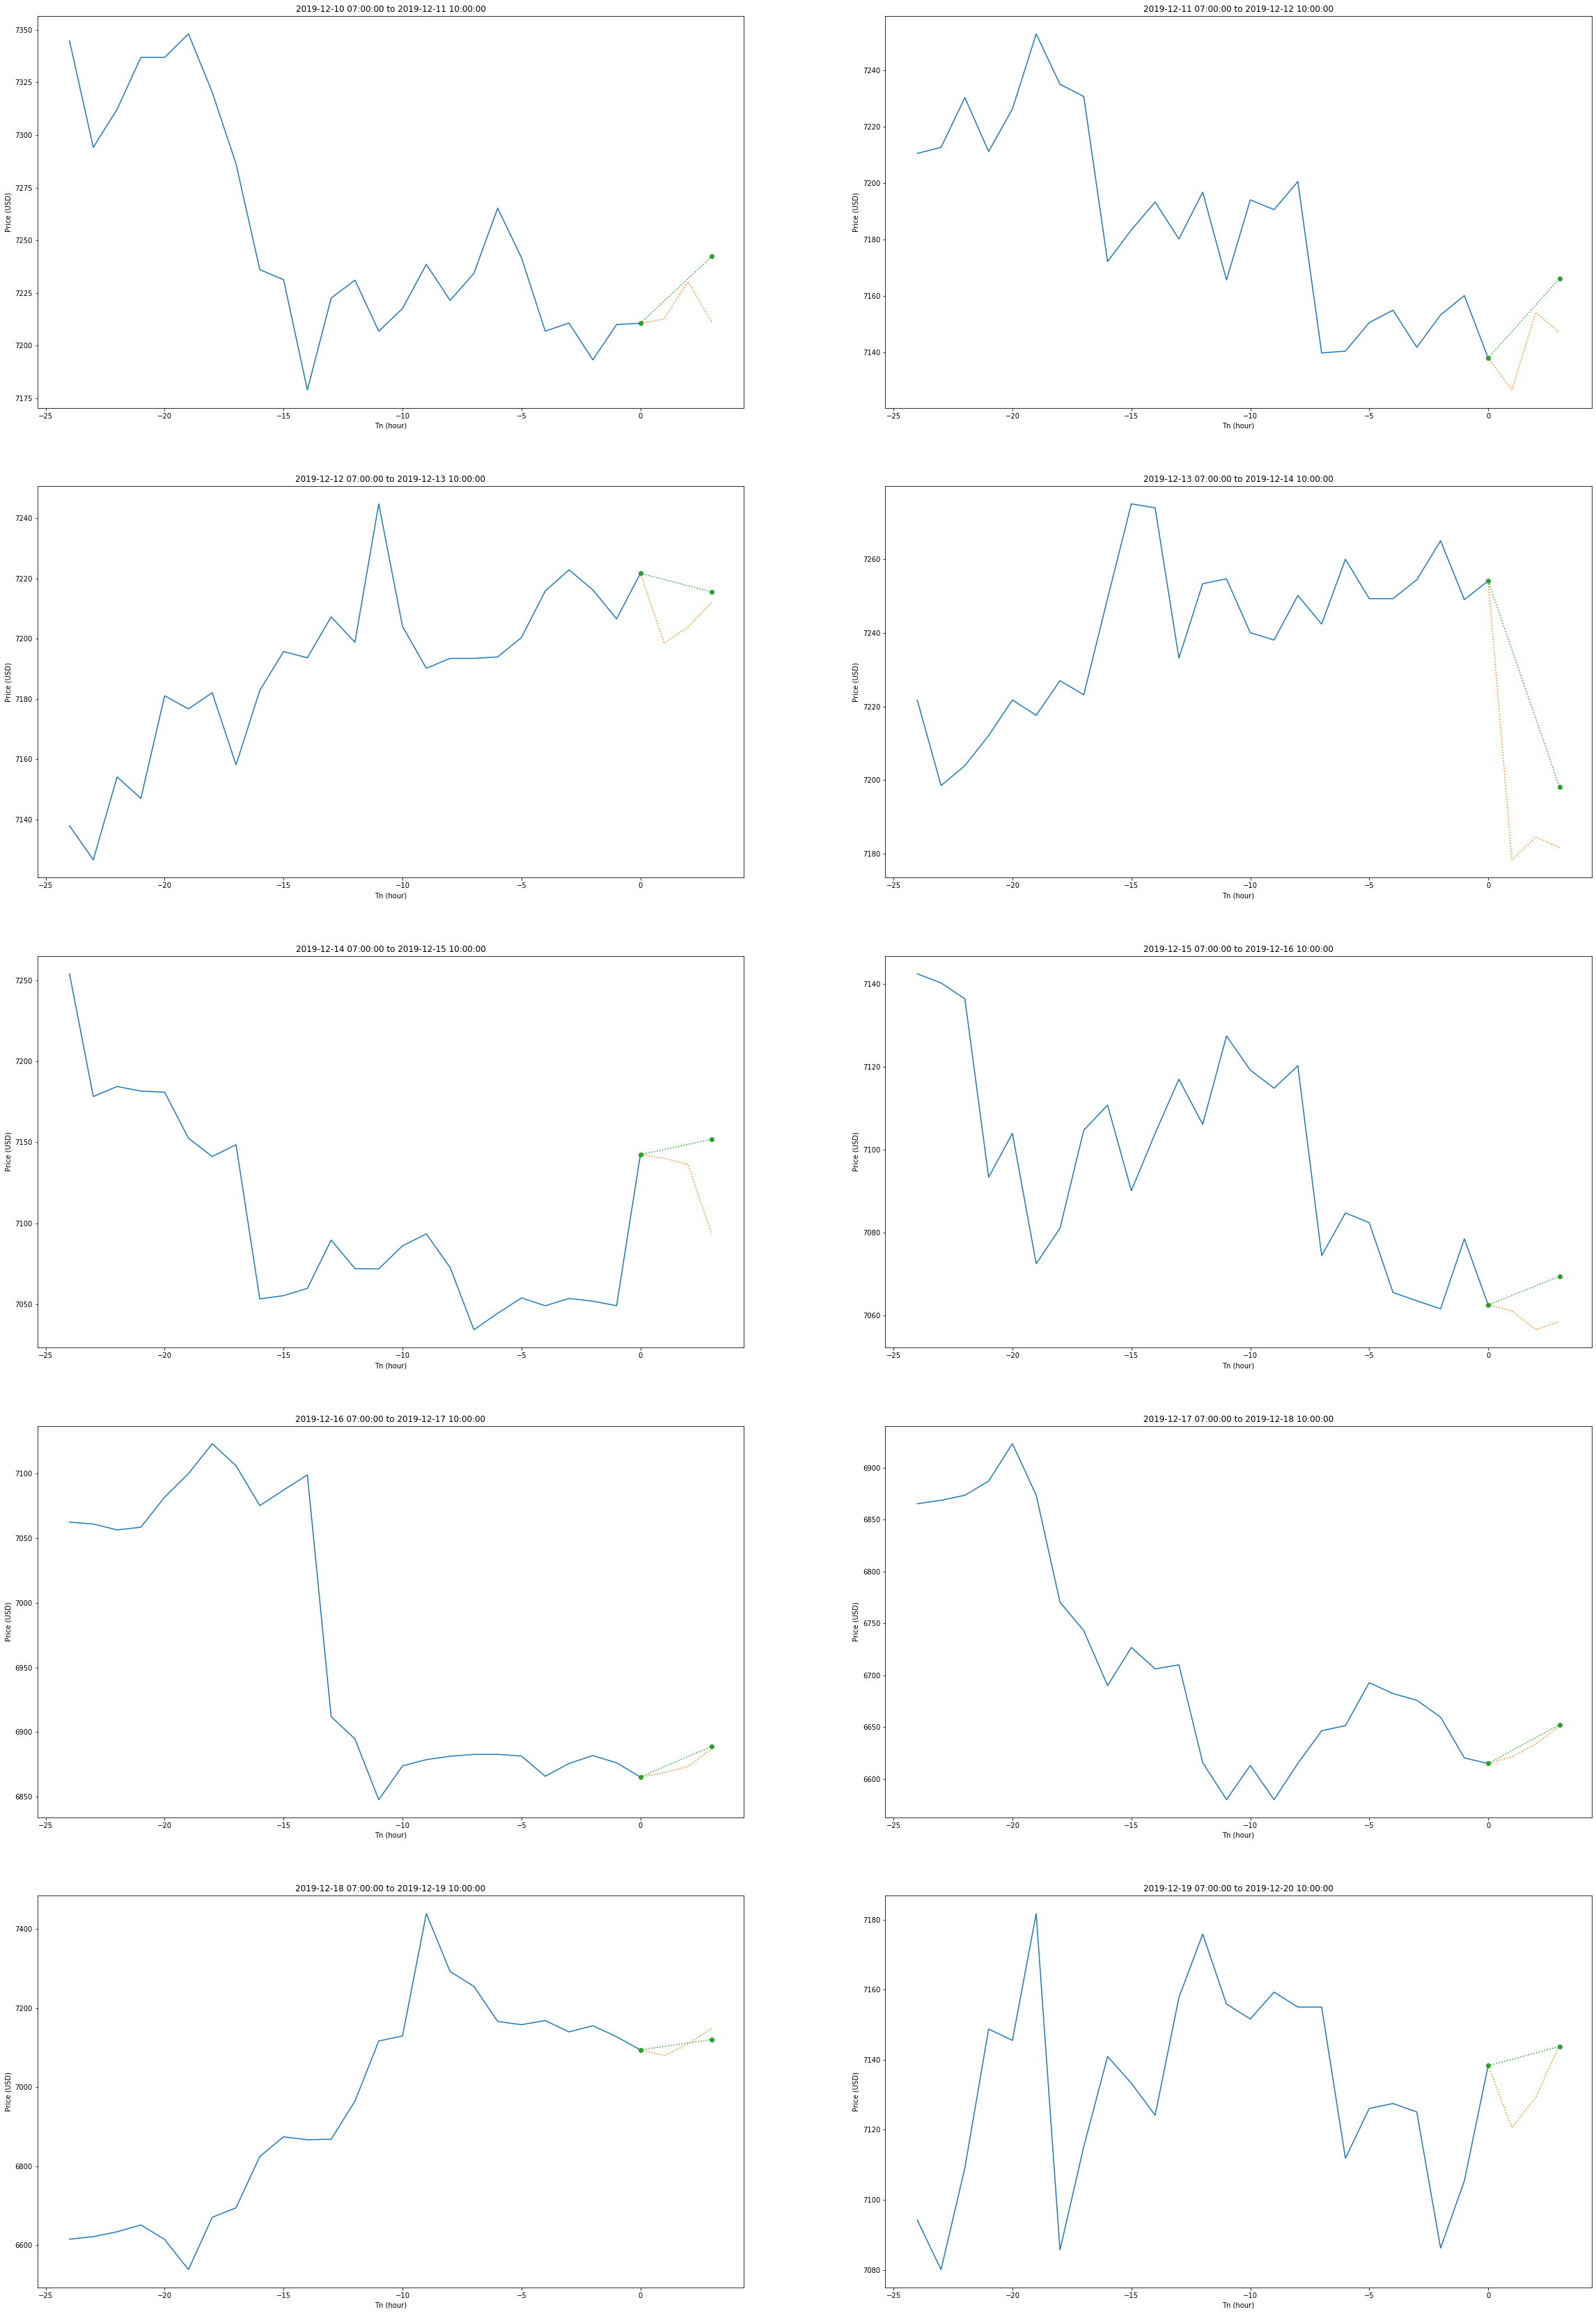

In [54]:
BIAS = 0

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(40, 60))

for i in range(3, 13):
    new_df = test_df.iloc[(INPUT_WIDTH*i):(INPUT_WIDTH*(i+1))+LABEL_SHIFT]
    input = tf.stack([row.values for _, row in new_df.iterrows()])[:-1]
    input = tf.expand_dims(input, axis=0)
    
    actual = ((model.predict(input)*STD)+MEAN)[0][0]
    expected = (tf.stack([row.values for _, row in new_df.iterrows()])[-1].numpy()[0]*STD)+MEAN
    
    new_df.loc[:, 'close'] = pd.Series((new_df['close_normal'].values*STD)+MEAN, index=new_df.index)
    
    
    if i%2 == 0:
        j = 1
    else:
        j = 0
    
    i = i-3
    map = {0: 0, 1: 0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4}
    i = map[i]
    if LABEL_SHIFT > 1:
        # axes[i].plot(new_df.index[:INPUT_WIDTH+1], new_df['close'][:INPUT_WIDTH+1])
        axes[i][j].plot([x for x in range(-INPUT_WIDTH, 1)], new_df['close'][:INPUT_WIDTH+1])
        # axes[i].plot(new_df.index[INPUT_WIDTH:], new_df['close'][INPUT_WIDTH:], linestyle='dotted')
        axes[i][j].plot([x for x in range(0, LABEL_SHIFT)], new_df['close'][INPUT_WIDTH:], linestyle='dotted')
#         axes[i].plot([new_df.index[INPUT_WIDTH], new_df.index[-1]], 
#                      [new_df['close'][INPUT_WIDTH], actual],
#                      marker='o', linestyle='dotted')
        axes[i][j].plot([0, LABEL_SHIFT-1], 
                     [new_df['close'][INPUT_WIDTH], actual],
                     marker='o', linestyle='dotted')
        axes[i][j].set_title(f'{new_df.index[0]} to {new_df.index[-1]}')
        axes[i][j].set_xlabel('Tn (hour)')
        axes[i][j].set_ylabel('Price (USD)')
    else:
        axes[i].plot(new_df.index, new_df['close'])
        axes[i].plot(new_df.index[-1], actual, marker='o')
    print(f'Diff is {actual-expected}')

plt.show()

In [55]:
model.save('BTC_USD_122448EMAs')

ValueError: Layer has 2 states but was passed 0 initial states.